In [1]:
import sys
sys.path.append('/Applications/NEURON-7.7/nrn/lib/python')

In [2]:
import numpy as np
from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.auxi.node_params import positions_columinar, xiter_random

In [3]:
import bmtk

In [4]:
bmtk.__version__

'0.0.8'

In [5]:
from bmtk.builder.networks import NetworkBuilder

In [6]:
from bmtk.utils.sim_setup import build_env_bionet

In [7]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
MPI_RANK = comm.Get_rank()

## example tutorial

In [7]:
cortex = NetworkBuilder('mcortex')
cortex.add_nodes(N=100,
                 pop_name='Scnn1a',
                 positions=positions_columinar(N=100, center=[0, 50.0, 0], max_radius=30.0, height=100.0),
                 rotation_angle_yaxis=xiter_random(N=100, min_x=0.0, max_x=2*np.pi),
                 rotation_angle_zaxis=3.646878266,
                 potental='exc',
                 model_type='biophysical',
                 model_template='ctdb:Biophys1.hoc',
                 model_processing='aibs_perisomatic',
                 dynamics_params='472363762_fit.json',
                 morphology='Scnn1a_473845048_m.swc')

In [8]:
from bmtk.builder.auxi.edge_connectors import distance_connector

cortex.add_edges(source={'pop_name': 'Scnn1a'}, target={'pop_name': 'Scnn1a'},
                 connection_rule=distance_connector,
                 connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 50.0, 'nsyn_min': 0, 'nsyn_max': 10},
                 syn_weight=2.0e-04,
                 distance_range=[30.0, 150.0],
                 target_sections=['basal', 'apical', 'soma'],
                 delay=2.0,
                 dynamics_params='AMPA_ExcToExc.json',
                 model_template='exp2syn')

In [9]:
cortex.build()
cortex.save_nodes(output_dir='sim_ch03b/network')
cortex.save_edges(output_dir='sim_ch03b/network')

In [10]:

thalamus = NetworkBuilder('mthalamus')
thalamus.add_nodes(N=10,
                   pop_name='tON',
                   potential='exc',
                   model_type='virtual')

In [11]:
from bmtk.builder.auxi.edge_connectors import connect_random

thalamus.add_edges(source=thalamus.nodes(), target=cortex.nodes(),
                   connection_rule=connect_random,
                   connection_params={'nsyn_min': 0, 'nsyn_max': 12},
                   syn_weight=1.0e-04,
                   distance_range=[0.0, 150.0],
                   target_sections=['basal', 'apical'],
                   delay=2.0,
                   dynamics_params='AMPA_ExcToExc.json',
                   model_template='exp2syn')

thalamus.build()
thalamus.save_nodes(output_dir='sim_ch03b/network')
thalamus.save_edges(output_dir='sim_ch03b/network')

In [12]:
thalamus.build()
thalamus.save_nodes(output_dir='sim_ch03b/network')
thalamus.save_edges(output_dir='sim_ch03b/network')

In [13]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

psg = PoissonSpikeGenerator(population='mthalamus')
psg.add(node_ids=range(100),  # Have 10 nodes to match mthalamus
        firing_rate=30.0,    # 15 Hz, we can also pass in a nonhomoegenous function/array
        times=(0.0, 3.0))    # Firing starts at 0 s up to 3 s
psg.to_sonata('sim_ch03b/inputs/mthalamus_spikes.h5')

# Let's do a quick check that we have reasonable results. Should see somewhere on the order of 15*3*100 = 4500
# spikes
psg.to_dataframe()

,node_ids,timestamps,population
0,0,0.043627,mthalamus
1,0,0.081996,mthalamus
2,0,0.172986,mthalamus
3,0,0.191200,mthalamus
4,0,0.207965,mthalamus
...,...,...,...
8950,99,2.879825,mthalamus
8951,99,2.879996,mthalamus
8952,99,2.920838,mthalamus
8953,99,2.923929,mthalamus


In [8]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='sim_ch03b',      
                 network_dir='sim_ch03b/network',
                 tstop=3000.0, dt=0.1,
                 report_vars=['v', 'cai'],     # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('mthalamus',   # Name of population which spikes will be generated for
                                'sim_ch03b/inputs/mthalamus_spikes.h5')],
                 include_examples=True,    # Copies components files
                 compile_mechanisms=True   # Will try to compile NEURON mechanisms
                )

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('sim_ch03b/simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2020-04-30 00:53:55,029 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2020-04-30 00:53:55,326 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2020-04-30 00:54:03,802 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2020-04-30 00:54:04,371 [INFO] Building virtual cell stimulations for mthalamus_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for mthalamus_spikes


2020-04-30 00:54:07,066 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.100 ms


2020-04-30 00:54:07,067 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2020-04-30 00:54:07,069 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2020-04-30 00:54:25,375 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2020-04-30 00:54:46,793 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2020-04-30 00:55:09,358 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2020-04-30 00:55:32,140 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2020-04-30 00:56:06,121 [INFO]     step:25000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms


2020-04-30 00:56:40,623 [INFO]     step:30000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms


2020-04-30 00:56:40,642 [INFO] Simulation completed in 2.0 minutes, 33.58 seconds 


INFO:NEURONIOUtils:Simulation completed in 2.0 minutes, 33.58 seconds 


In [16]:
# from bmtk.analyzer.spike_trains import plot_raster

# plot_raster(config_file='sim_ch03b/output/simulation_config.json')

/Users/danieljdenman/opt/anaconda3/envs/nest/lib/python3.7/site-packages/bmtk-0.0.8-py3.7.egg/bmtk/simulator/utils/config.py:4: UserWarning: Please use bmtk.simulator.core.simulation_config instead.
  warnings.warn('Please use bmtk.simulator.core.simulation_config instead.')


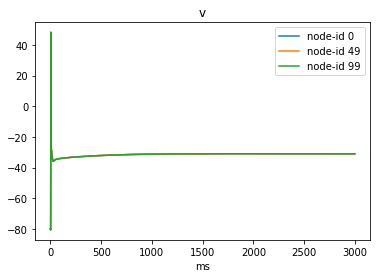

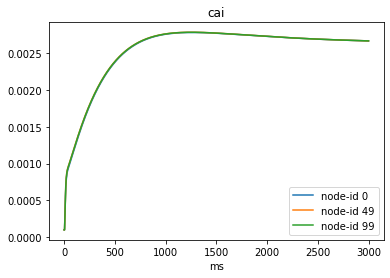

In [17]:
from bmtk.analyzer.cell_vars import plot_report

plot_report(config_file='sim_ch03b/output/simulation_config.json', node_ids=[0, 49, 99])

# use yazan's big mouse v1 model

a raw cell, for executing the below from the command line to set up the json to call to run the simulation

remake the full network into a tiny one for debugging

In [23]:
network_dir='/Users/danieljdenman/Academics/cu/_science/models/V1\ Network\ Models\ from\ the\ Allen\ Institute/Biophysical_network/network'
n_v1_cells = 2309

In [12]:
import h5py as h5
import glob,os,sys
import matplotlib.pyplot as plt

In [13]:
config_h5s = {}
for f in glob.glob(network_dir+'/*.h5'):
    config_h5s[os.path.basename(f).strip('.h5')] = h5.File(f)


In [18]:
f = h5.File('/Users/danieljdenman/Desktop/v1_nodes.h5')

/Users/danieljdenman/opt/anaconda3/envs/nest/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [32]:
print(d_v1_node_ids.tolist())

[1, 19, 56, 150, 298, 315, 484, 742, 810, 841, 1103, 1159, 1235, 1295, 1307, 1414, 1417, 1585, 1638, 2070, 2425, 2527, 2629, 2836, 2969, 3030, 3158, 3262, 3292, 3534, 3627, 3686, 3714, 3852, 4089, 4091, 4225, 4295, 4323, 4582, 4701, 4975, 4999, 5064, 5086, 5394, 5408, 5747, 5953, 6071, 6386, 6756, 6965, 7136, 7290, 7308, 7355, 7623, 7753, 7765, 8043, 8072, 8159, 8441, 8628, 8708, 8815, 8865, 8966, 9058, 9096, 9102, 9171, 9333, 9491, 9613, 9775, 9923, 9937, 10137, 10166, 10195, 10392, 10467, 10561, 10604, 10670, 10741, 10782, 10813, 10919, 10953, 11092, 11113, 11150, 11211, 11299, 11319, 11492, 11509, 11665, 11753, 11774, 11811, 11824, 11973, 12359, 12432, 12505, 12623, 12625, 12677, 12738, 13306, 13434, 13537, 13590, 13643, 13668, 13684, 13982, 14051, 14250, 14283, 14314, 14557, 14656, 14680, 14719, 14731, 15016, 15179, 15204, 15223, 15262, 15678, 15746, 15802, 15943, 15944, 16143, 16205, 16420, 16571, 16621, 16754, 16960, 17007, 17012, 17175, 17283, 17311, 17327, 17352, 17460, 17519, 

In [24]:
d_v1_node_ids = np.sort(np.random.randint(0,230923,n_v1_cells))
# d_v1_node_ids = np.arange(2000)

In [29]:
d_v1_node_ids.tofile('/Users/danieljdenman/Desktop/random01percent.npy')

In [21]:
import numpy as np

In [16]:
f2 = h5.File(os.path.join(os.getcwd(),network_dir)+'/v1_nodes_debug.h5','w')
g = f2.create_group('nodes')
gg = g.create_group('v1')
ggg = gg.create_group('0')

OSError: Unable to create file (unable to open file: name = '/Users/danieljdenman/github/djd_notebooks/sim_v1_dbs/network_debug/v1_nodes_debug.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [17]:
for k in list (config_h5s['v1_nodes']['nodes']['v1'].keys()):
    print(k)
    print(np.shape(np.array(config_h5s['v1_nodes']['nodes']['v1'][k])))
    if 'node' in k:
        f2['nodes']['v1'].create_dataset(k, (d_v1_node_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['v1_nodes']['nodes']['v1'][k].dtype)
        f2['nodes']['v1'][k][:] = config_h5s['v1_nodes']['nodes']['v1'][k][d_v1_node_ids]
    else: 
        if k == '0':
            for kk in list (config_h5s['v1_nodes']['nodes']['v1'][k].keys()):
                f2['nodes']['v1']['0'].create_dataset(kk, (d_v1_node_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['v1_nodes']['nodes']['v1']['0'][kk].dtype)
                f2['nodes']['v1']['0'][kk][:] = config_h5s['v1_nodes']['nodes']['v1']['0'][kk][d_v1_node_ids]
        else:
            config_h5s['v1_nodes']['nodes']['v1'].copy(k,f2['nodes']['v1'])
        

0
(5,)
node_group_id
(230924,)
node_group_index
(230924,)
node_id
(230924,)
node_type_id
(230924,)


In [18]:
sources  = np.isin(np.array(config_h5s['v1_v1_edges']['edges']['v1_to_v1']['source_node_id']),d_v1_node_ids)
targets  = np.isin(np.array(config_h5s['v1_v1_edges']['edges']['v1_to_v1']['target_node_id']),d_v1_node_ids)
d_v1_edge_ids = np.argwhere(np.logical_and(sources,targets)==1).flatten()

In [19]:
f2 = h5.File(os.path.join(os.getcwd(),network_dir)+'/v1_v1_edges_debug.h5','w')
g = f2.create_group('edges')
gg = g.create_group('v1_to_v1')
gg1 = gg.create_group('0')
gg2 = gg.create_group('indicies')
gg21= gg2.create_group('source_to_target')
gg22= gg2.create_group('target_to_source')

In [20]:
for k in list (config_h5s['v1_v1_edges']['edges']['v1_to_v1'].keys()):
    print(k)
    try:    print(np.shape(np.array(config_h5s['v1_v1_edges']['edges']['v1_to_v1'][k])))
    except: pass
    if 'node' in k:
        f2['edges']['v1_to_v1'].create_dataset(k, (d_v1_edge_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['v1_v1_edges']['edges']['v1_to_v1'][k].dtype)
        f2['edges']['v1_to_v1'][k][:] = config_h5s['v1_v1_edges']['edges']['v1_to_v1'][k][d_v1_edge_ids]
    else:
        if 'edge' in k:
            f2['edges']['v1_to_v1'].create_dataset(k, (d_v1_edge_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['v1_v1_edges']['edges']['v1_to_v1'][k].dtype)
            f2['edges']['v1_to_v1'][k][:] = config_h5s['v1_v1_edges']['edges']['v1_to_v1'][k][d_v1_edge_ids]
        else: 
            if k == '0':
                for kk in list (config_h5s['v1_v1_edges']['edges']['v1_to_v1'][k].keys()):
                    f2['edges']['v1_to_v1']['0'].create_dataset(kk, (d_v1_edge_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['v1_v1_edges']['edges']['v1_to_v1']['0'][kk].dtype)
                    f2['edges']['v1_to_v1']['0'][kk][:] = config_h5s['v1_v1_edges']['edges']['v1_to_v1']['0'][kk][d_v1_edge_ids]

k='source_to_target'
kk='node_id_to_range'
f2['edges']['v1_to_v1']['indicies'][k].create_dataset(kk, (d_v1_node_ids.shape[0],2),  maxshape=( (None )),dtype=config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk].dtype)
f2['edges']['v1_to_v1']['indicies'][k][kk][:] = config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk][d_v1_node_ids,:]
kk='range_to_edge_id'
f2['edges']['v1_to_v1']['indicies'][k].create_dataset(kk, (d_v1_edge_ids.shape[0],2),  maxshape=( (None )),dtype=config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk].dtype)
f2['edges']['v1_to_v1']['indicies'][k][kk][:] = config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk][d_v1_edge_ids,:]

k='target_to_source'
kk='node_id_to_range'
f2['edges']['v1_to_v1']['indicies'][k].create_dataset(kk, (d_v1_node_ids.shape[0],2),  maxshape=( (None )),dtype=config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk].dtype)
f2['edges']['v1_to_v1']['indicies'][k][kk][:] = config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk][d_v1_node_ids,:]
kk='range_to_edge_id'
f2['edges']['v1_to_v1']['indicies'][k].create_dataset(kk, (d_v1_node_ids.shape[0],2),  maxshape=( (None )),dtype=config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk].dtype)
f2['edges']['v1_to_v1']['indicies'][k][kk][:] = config_h5s['v1_v1_edges']['edges']['v1_to_v1']['indicies'][k][kk][d_v1_node_ids,:]


0
edge_group_id
(70139111,)
edge_group_index
(70139111,)
edge_type_id
(70139111,)
indicies
(2,)
source_node_id
(70139111,)
target_node_id
(70139111,)


In [21]:
f2.close()

In [30]:
f2['edges']['v1_to_v1']['indicies']['source_to_target'].keys()

<KeysViewHDF5 []>

In [ ]:
config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'].keys()

In [31]:
targets  = np.isin(np.array(config_h5s['bkg_v1_edges']['edges']['bkg_to_v1']['target_node_id']),d_v1_node_ids)
d_bkg_edge_ids = np.argwhere(targets==1).flatten()

In [32]:
f2 = h5.File(os.path.join(os.getcwd(),network_dir)+'/bkg_v1_edges_debug.h5','w')
g = f2.create_group('edges')
gg = g.create_group('bkg_to_v1')

In [33]:
for k in list (config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'].keys()):
    print(k)
    try:    print(np.shape(np.array(config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'][k])))
    except: pass
    if 'node' in k:
        f2['edges']['bkg_to_v1'].create_dataset(k, (d_bkg_edge_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'][k].dtype)
        f2['edges']['bkg_to_v1'][k][:] = config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'][k][d_bkg_edge_ids]
    else:
        if 'edge' in k:
            f2['edges']['bkg_to_v1'].create_dataset(k, (d_bkg_edge_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'][k].dtype)
            f2['edges']['bkg_to_v1'][k][:] = config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'][k][d_bkg_edge_ids]
        else: 
            config_h5s['bkg_v1_edges']['edges']['bkg_to_v1'].copy(k,f2['edges']['bkg_to_v1'])

0
edge_group_id
(230924,)
edge_group_index
(230924,)
edge_type_id
(230924,)
indicies
(2,)
source_node_id
(230924,)
target_node_id
(230924,)


In [44]:
f2.close()

In [34]:
targets  = np.isin(np.array(config_h5s['lgn_v1_edges']['edges']['lgn_to_v1']['target_node_id']),d_v1_node_ids)
d_lgn_edge_ids = np.argwhere(targets==1).flatten()

In [35]:
f2 = h5.File(os.path.join(os.getcwd(),network_dir)+'/lgn_v1_edges_debug.h5','w')
g = f2.create_group('edges')
gg = g.create_group('lgn_to_v1')

In [36]:
for k in list (config_h5s['lgn_v1_edges']['edges']['lgn_to_v1'].keys()):
    print(k)
    try:    print(np.shape(np.array(config_h5s['lgn_v1_edges']['edges']['bkg_to_v1'][k])))
    except: pass
    if 'node' in k:
        f2['edges']['lgn_to_v1'].create_dataset(k, (d_lgn_edge_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['lgn_v1_edges']['edges']['lgn_to_v1'][k].dtype)
        f2['edges']['lgn_to_v1'][k][:] = config_h5s['lgn_v1_edges']['edges']['lgn_to_v1'][k][d_lgn_edge_ids]
    else:
        if 'edge' in k:
            f2['edges']['lgn_to_v1'].create_dataset(k, (d_lgn_edge_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['lgn_v1_edges']['edges']['lgn_to_v1'][k].dtype)
            f2['edges']['lgn_to_v1'][k][:] = config_h5s['lgn_v1_edges']['edges']['lgn_to_v1'][k][d_lgn_edge_ids]
        else: 
            config_h5s['lgn_v1_edges']['edges']['lgn_to_v1'].copy(k,f2['edges']['lgn_to_v1'])

0
edge_group_id
edge_group_index
edge_type_id
indicies
source_node_id
target_node_id


In [37]:
d_lgn_node_ids = np.sort(np.array(config_h5s['lgn_v1_edges']['edges']['lgn_to_v1']['source_node_id'])[d_lgn_edge_ids])

In [38]:
f2 = h5.File(os.path.join(os.getcwd(),network_dir)+'/lgn_nodes_debug.h5','w')
g = f2.create_group('nodes')
gg = g.create_group('lgn')

In [39]:
for k in list (config_h5s['lgn_nodes']['nodes']['lgn'].keys()):
    print(k)
    print(np.shape(np.array(config_h5s['lgn_nodes']['nodes']['lgn'][k])))
    if 'node' in k:
        f2['nodes']['lgn'].create_dataset(k, (d_lgn_node_ids.shape[0],),  maxshape=( (None )),dtype=config_h5s['lgn_nodes']['nodes']['lgn'][k].dtype)
        f2['nodes']['lgn'][k][:] = config_h5s['lgn_nodes']['nodes']['lgn'][k][d_lgn_node_ids]
    else: 
        config_h5s['lgn_nodes']['nodes']['lgn'].copy(k,f2['nodes']['lgn'])

0
(9,)
1
(17,)
node_group_id
(17400,)


TypeError: Indexing elements must be in increasing order

In [40]:
f2.close()

run the simulation

In [12]:
from bmtk.utils.sim_setup import build_env_bionet
build_env_bionet(base_dir='sim_v1_dbs',      
                 network_dir=network_dir,
                 tstop=500.0, dt=0.1,
                 report_vars=['v','spikes'],     # Record membrane potential and spikes
                 include_examples=True,    # Copies components files
                 compile_mechanisms=True   # Will try to compile NEURON mechanisms
                )

manually added the extracellular input to stimulation_config.json

In [8]:
from bmtk.simulator.bionet.pyfunction_cache import synaptic_weight

In [9]:
@synaptic_weight
def DirectionRule_others(edge_props, src_node, trg_node):
    nsyn = 1 # edge_props['nsyns']
    sigma = edge_props['weight_sigma']
    src_tuning = src_node['tuning_angle']
    tar_tuning = trg_node['tuning_angle']

    delta_tuning_180 = abs(abs((abs(tar_tuning - src_tuning) % 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)
    return w_multiplier_180 * edge_props['syn_weight']


@synaptic_weight
def DirectionRule_EE(edge_props, src_node, trg_node):
    nsyn = 1 # edge_props['nsyns']
    sigma = edge_props['weight_sigma']

    src_tuning = src_node['tuning_angle']
    x_src = src_node['x']
    z_src = src_node['z']

    tar_tuning = trg_node['tuning_angle']
    x_tar = trg_node['x']
    z_tar = trg_node['z']

    delta_tuning_180 = abs(abs((abs(tar_tuning - src_tuning) % 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)

    delta_x = (x_tar - x_src) * 0.07
    delta_z = (z_tar - z_src) * 0.04

    theta_pref = tar_tuning * (np.pi / 180.)
    xz = delta_x * np.cos(theta_pref) + delta_z * np.sin(theta_pref)
    sigma_phase = 1.0
    phase_scale_ratio = np.exp(- (xz ** 2 / (2 * sigma_phase ** 2)))

    # To account for the 0.07 vs 0.04 dimensions. This ensures
    # the horizontal neurons are scaled by 5.5/4 (from the midpoint
    # of 4 & 7). Also, ensures the vertical is scaled by 5.5/7. This
    # was a basic linear estimate to get the numbers (y = ax + b).
    theta_tar_scale = abs(abs(abs(180.0 - abs(tar_tuning) % 360.0) - 90.0) - 90.0)
    phase_scale_ratio = phase_scale_ratio * (5.5 / 4 - 11. / 1680 * theta_tar_scale)

    return w_multiplier_180 * phase_scale_ratio * edge_props['syn_weight']


In [10]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('sim_v1_dbs/simulation_config_debug.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

FileNotFoundError: [Errno 2] No such file or directory: 'sim_v1_dbs/simulation_config_debug.json'